# *Loan Default Risk with Business Cost Optimization*

<p style='font-size:20px;'><i>The objective of this task is to predict the likelihood of a loan default and optimize the decision threshold based on cost-benefit analysis. We will train binary classification models like Logistic Regression and CatBoost. We will define business cost values for false positives and false negatives and adjust the model threshold to minimize total business cost</i></p>

## *Data Cleaning and Preprocessing*

In [3]:
# Import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the dataset into a pandas dataframe
df = pd.read_csv('credit_risk_dataset.csv')

In [5]:
# Display the intial five rows of the dataset
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
# Get the number of rows and columns of the dataset
df.shape

(32581, 12)

In [7]:
# Display a concise overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [8]:
# Display statistical summary of numerical features
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [9]:
# Check for null values in the dataset
print('Count of null rows = ', df.isnull().any(axis=1).sum())
print(df.isnull().sum())

Count of null rows =  3943
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [10]:
# Check for any duplicate rows in the dataset
print('Count of duplicated rows = ', df.duplicated().sum())

Count of duplicated rows =  165


In [12]:
# Display the duplicated rows
duplicate_rows = df[df.duplicated(keep='first')]
duplicate_rows

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


In [13]:
# Drop the nulls from the dataset
df.dropna(inplace=True)

In [14]:
# Drop the duplicate rows from the dataset
df.drop_duplicates(inplace=True)

In [15]:
# Again check for any nulls or duplicates
print('Count of null rows = ', df.isnull().any(axis=1).sum())
print('Count of duplicated rows = ', df.duplicated().sum())

Count of null rows =  0
Count of duplicated rows =  0


## *Exploratory Data Analysis*

<Axes: xlabel='person_age'>

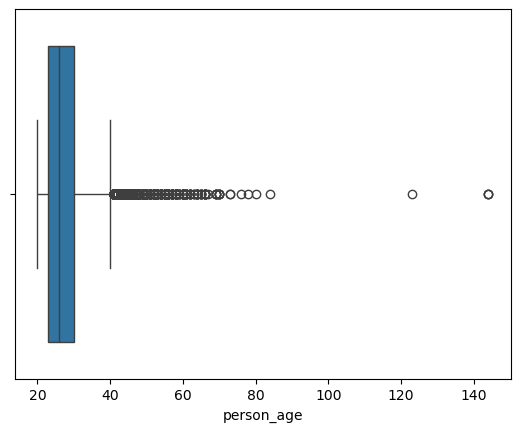

In [19]:
# Create a boxplot to visualize the distribution of ages in the dataset
sns.boxplot(x=df['person_age'])

<Axes: xlabel='person_income'>

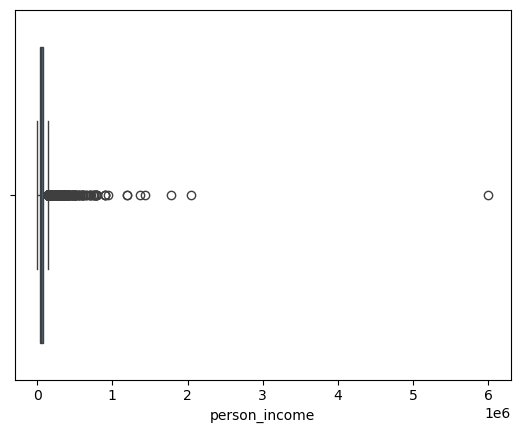

In [20]:
# Create a boxplot to visualize the distribution of income in the dataset
sns.boxplot(x=df['person_income'])

<Axes: xlabel='person_emp_length'>

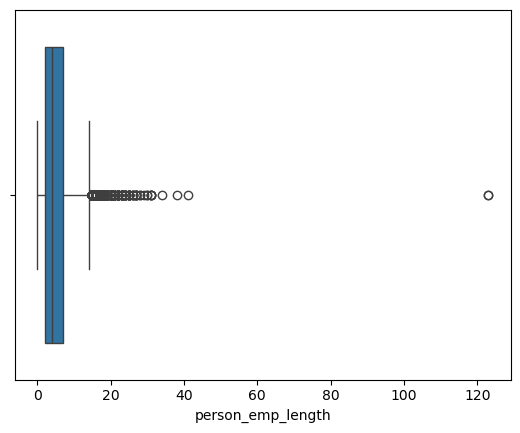

In [23]:
# Create a boxplot to visualize the distribution of employment years in the dataset
sns.boxplot(x=df['person_emp_length'])

In [24]:
# Remove outliers from person_age column using the IQR method (keeping values within Q1-1.5*IQR and Q3+1.5*IQR)
Q1 = df['person_age'].quantile(0.25)
Q3 = df['person_age'].quantile(0.75)
IQR = Q3-Q1
df = df[~((df['person_age']<(Q1-1.5*IQR)) | (df['person_age']>(Q3+1.5*IQR)))]

<Axes: xlabel='person_age'>

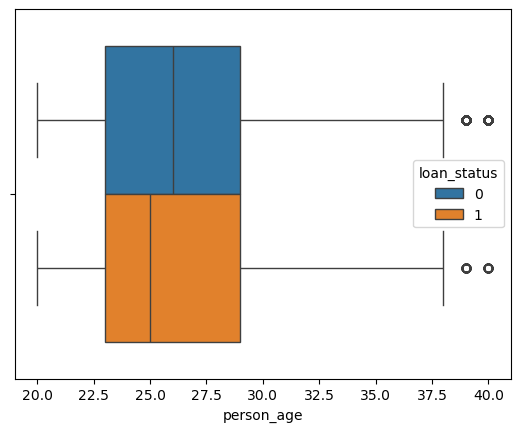

In [28]:
sns.boxplot(x=df['person_age'], hue=df['loan_status'])

In [26]:
# Remove outliers from person_income column using the IQR method (keeping values within Q1-1.5*IQR and Q3+1.5*IQR)
Q1 = df['person_income'].quantile(0.25)
Q3 = df['person_income'].quantile(0.75)
IQR=Q3-Q1
df=df[~((df['person_income']<(Q1-1.5*IQR))|(df['person_income']>(Q3+1.5*IQR)))]

<Axes: xlabel='person_income'>

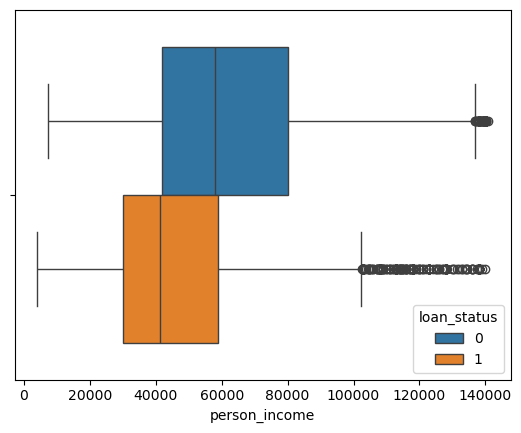

In [29]:
sns.boxplot(x=df['person_income'], hue=df['loan_status'])

In [30]:
# Remove outliers from person_emp_length column using the IQR method (keeping values within Q1-1.5*IQR and Q3+1.5*IQR)
Q1 = df['person_emp_length'].quantile(0.25)
Q3 = df['person_emp_length'].quantile(0.75)
IQR=Q3-Q1
df=df[~((df['person_emp_length']<(Q1-1.5*IQR))|(df['person_emp_length']>(Q3+1.5*IQR)))]

<Axes: xlabel='person_emp_length'>

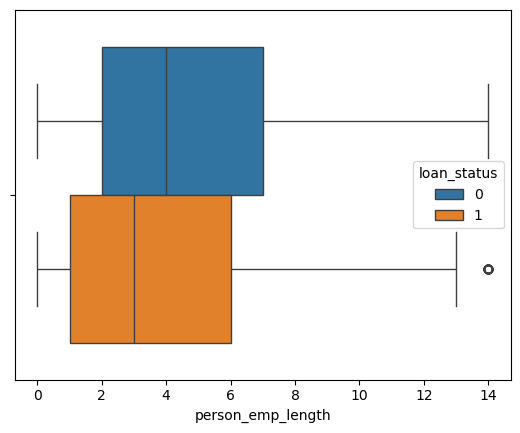

In [31]:
sns.boxplot(x=df['person_emp_length'], hue=df['loan_status'])

In [32]:
# Display the statistics after removing the outliers
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,25428.000000,25428.000000,25428.000000,25428.000000,25428.000000,25428.000000,25428.000000,25428.000000
mean,26.567209,58804.614519,4.375649,9319.025287,11.041304,0.224162,0.174093,5.171818
std,4.389214,27285.443661,3.387053,6026.780250,3.220328,0.417038,0.106658,3.239914
min,20.000000,4080.000000,0.000000,500.000000,5.420000,0.000000,0.010000,2.000000
25%,23.000000,38000.000000,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,25.000000,54000.000000,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,29.000000,75000.000000,7.000000,12000.000000,13.480000,0.000000,0.230000,7.000000
max,40.000000,140900.000000,14.000000,35000.000000,23.220000,1.000000,0.830000,17.000000


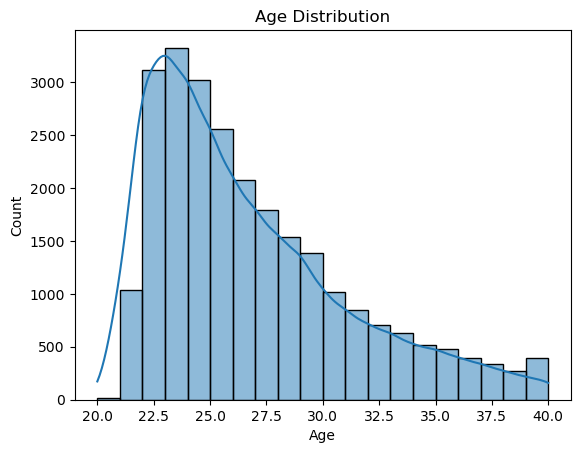

In [33]:
# Create a histogram of the age distribution with a KDE curve overlay
sns.histplot(x=df['person_age'], kde=True, bins=20, edgecolor='black')
plt.xlabel("Age")
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

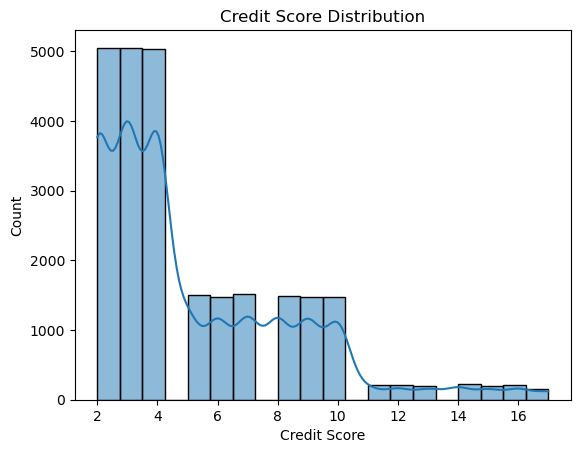

In [35]:
# Create a histogram of the credit score distribution with a KDE curve overlay
sns.histplot(x=df['cb_person_cred_hist_length'], bins=20, kde=True,edgecolor='black')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.title('Credit Score Distribution')
plt.show()

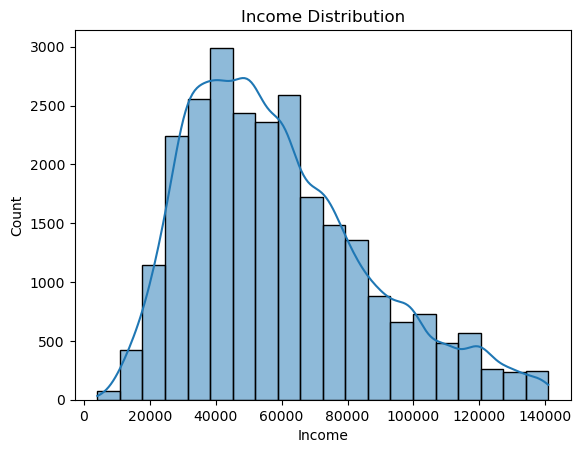

In [36]:
# Create a histogram of the income distribution with a KDE curve overlay
sns.histplot(x=df['person_income'], bins=20, kde=True, edgecolor='black')
plt.xlabel("Income")
plt.ylabel('Count')
plt.title('Income Distribution')
plt.show()

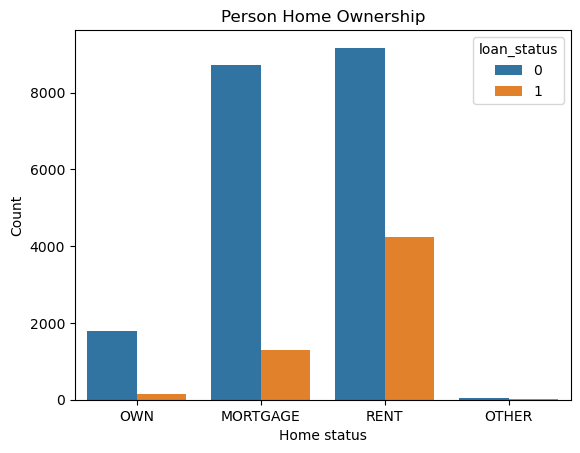

In [37]:
# Create a count plot showing the distribution of home ownership status
sns.countplot(x=df['person_home_ownership'], hue=df['loan_status'])
plt.xlabel('Home status')
plt.ylabel('Count')
plt.title('Person Home Ownership')
plt.show()

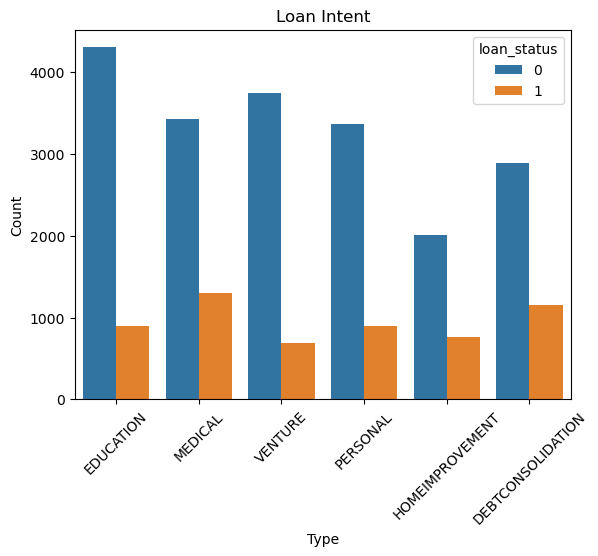

In [38]:
# Create a count plot showing the distribution of loan intent type
sns.countplot(x=df['loan_intent'], hue=df['loan_status'])
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Loan Intent')
plt.xticks(rotation=45)
plt.show()

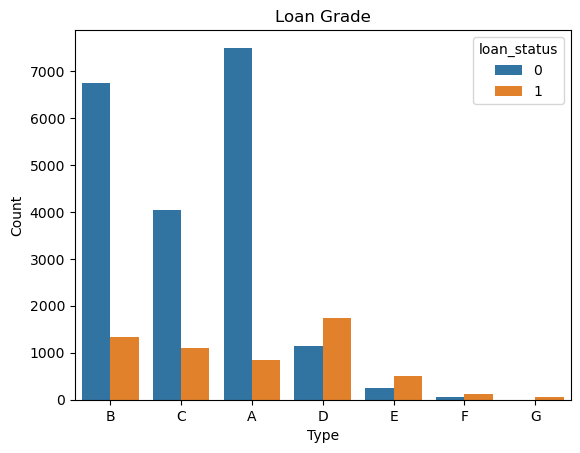

In [39]:
# Create a count plot showing the distribution of loan grade type
sns.countplot(x=df['loan_grade'], hue=df['loan_status'])
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Loan Grade')
plt.show()

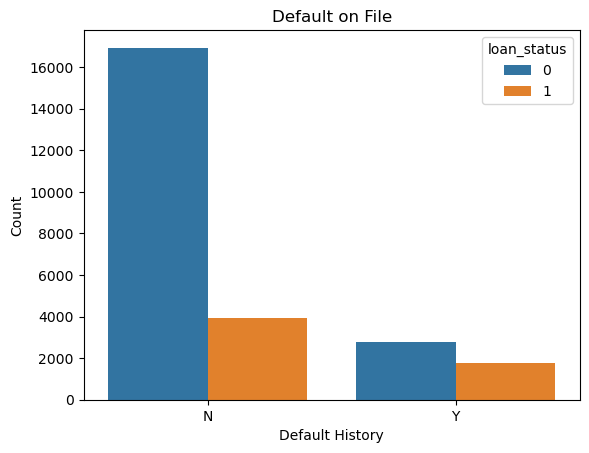

In [40]:
# Create a count plot showing the distribution of default on file history
sns.countplot(x=df['cb_person_default_on_file'], hue=df['loan_status'])
plt.xlabel('Default History')
plt.ylabel('Count')
plt.title('Default on File')
plt.show()

In [41]:
# Calculate the percentage distribution of loan statuses
df['loan_status'].value_counts(normalize=True) * 100

loan_status
0    77.583766
1    22.416234
Name: proportion, dtype: float64

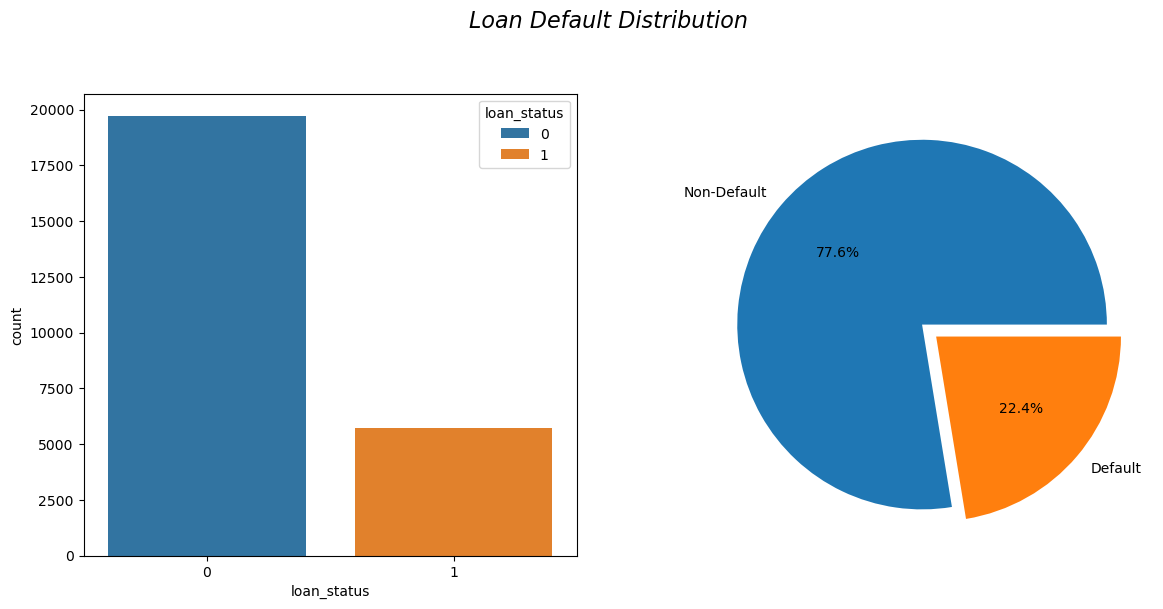

In [43]:
# Plotting a count plot and pie chart for the target 'Loan_Status'
plt.figure(figsize=(14,6))
# First subplot - count plot
plt.subplot(1,2,1)
sns.countplot(data=df, x="loan_status", hue='loan_status')
# Calculate the count of each value in the "Loan_Status" column
count = df["loan_status"].value_counts()
# Second subplot - pie chart
plt.subplot(1,2,2)
plt.pie(count.values, labels=['Non-Default', 'Default'], autopct="%1.1f%%",explode=[0, 0.1])
plt.suptitle("Loan Default Distribution", y=1.02, fontsize=16, style='italic')
plt.show()

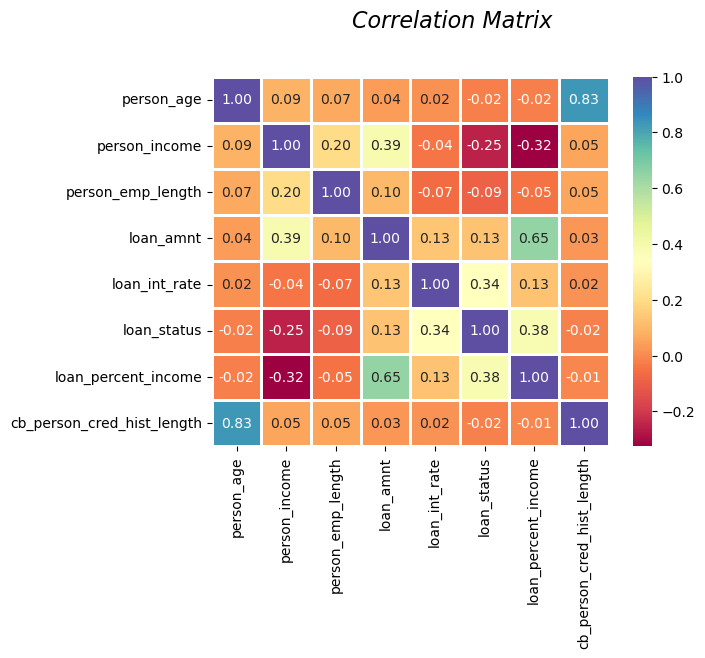

In [45]:
# Create a correlation matrix using heatmap
data_corr = df.corr(numeric_only=True)
sns.heatmap(data_corr, annot=True, cmap='Spectral', fmt='.2f', linewidth=1)
plt.suptitle('Correlation Matrix',y=1.02, fontsize=16, style='italic')
plt.show()

## *Feature Encoding*

In [46]:
# Display unique values for specific categorical columns
columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in columns:
    print(col, '-->', df[col].unique())

person_home_ownership --> ['OWN' 'MORTGAGE' 'RENT' 'OTHER']
loan_intent --> ['EDUCATION' 'MEDICAL' 'VENTURE' 'PERSONAL' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade --> ['B' 'C' 'A' 'D' 'E' 'F' 'G']
cb_person_default_on_file --> ['N' 'Y']


In [47]:
# Import OneHotEncoder from sklearn's preprocessing module
from sklearn.preprocessing import OneHotEncoder 

# Create an instance of the encoder
encoder = OneHotEncoder()

# Create a copy of the original dataframe to avoid modifying it directly
df_encoded = df.copy()

# Columns to encode
columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Initialize the encoder with proper parameters for categorical data
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

for col in columns:
    # Reshape the column data for the encoder
    encoded_data = encoder.fit_transform(df[[col]])
    
    # Get the new column names
    encoded_cols = [f"{col}_{category}" for category in encoder.categories_[0]]
    
    # Create a DataFrame with the encoded data
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df.index).astype(int)
    
    # Drop the original column and join the encoded columns
    df_encoded = df_encoded.drop(col, axis=1)
    df_encoded = df_encoded.join(encoded_df)

In [48]:
# Display the encoded dataframe
df_encoded

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32276,38,40000,5.0,10000,5.99,0,0.25,17,1,0,...,0,1,0,0,0,0,0,0,1,0
32287,36,44000,4.0,8000,17.49,1,0.18,15,0,0,...,0,0,0,0,1,0,0,0,1,0
32290,37,90000,11.0,4000,6.62,0,0.04,15,1,0,...,0,1,0,0,0,0,0,0,1,0
32293,38,110000,5.0,16000,11.99,0,0.15,13,1,0,...,0,0,1,0,0,0,0,0,1,0


## *Model Training*

### *Train Test Split*

In [49]:
# Import train-test_split from sklearn's model_selectiom module
from sklearn.model_selection import train_test_split

In [51]:
# Split the data into features (x) and target variable (y) 
x = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

In [52]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### *Addressing Data Imbalance*

In [53]:
# Import SMOTE (Synthetic Minority Over-sampling Technique) from imblearn library
from imblearn.over_sampling import SMOTE
# Initialize SMOTE 
sm = SMOTE(random_state=42)
# Apply SMOTE to balance the training data:
x_train_bal, y_train_bal = sm.fit_resample(x_train, y_train)

### *Feature Scaling*

In [54]:
# Import StandardScaler from sklearn's preprocessing module
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler object 
scaler = StandardScaler()

In [55]:
# Create a list of numerical features
numeric_cols = ['person_age', 'person_income', 'person_emp_length',	'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
# Fit the scaler to the training data and transform it
x_train_bal[numeric_cols] = scaler.fit_transform(x_train_bal[numeric_cols])
# Transform the test data using the same scaler
x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

In [56]:
# Display the scaled and encoded dataframe
x_train_bal

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,-0.805826,-0.241968,0.255387,-1.133499,0.029308,-1.240270,-0.650455,0,0,1,...,1,0,1,0,0,0,0,0,1,0
1,1.854370,-0.167976,-1.309994,-0.970741,0.069847,-1.075776,0.661125,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,-0.080318,0.164212,-0.683842,-0.753731,-0.762749,-0.993529,-0.650455,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,-1.047662,-0.315960,-0.370765,0.331320,-0.017467,0.486917,-0.322560,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,2.579879,0.050301,-0.996918,1.106357,-0.956086,0.815905,1.972705,1,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31523,-0.080318,-0.167976,-1.277364,1.261364,-0.920008,1.309387,0.989020,0,0,0,...,0,0,0,0,0,0,0,0,1,0
31524,0.403354,-0.463944,-1.214085,-0.753731,0.965105,-0.664541,-0.322560,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31525,1.128862,0.676903,-1.004364,0.846719,1.156784,0.102446,0.333230,0,0,0,...,0,0,0,0,1,0,0,0,0,0
31526,-0.805826,-0.890730,0.590672,-1.063746,0.945778,-0.829035,-0.978349,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## *Logistic Regression Model*

In [57]:
# Import Logistic Regression and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,ConfusionMatrixDisplay, recall_score,precision_score,f1_score,roc_auc_score,roc_curve,auc, log_loss

In [58]:
# Initialize a logisticRegression model
model = LogisticRegression(class_weight='balanced')
# Train the model
model.fit(x_train_bal,y_train_bal)

LogisticRegression(class_weight='balanced')

In [59]:
# Make model predictions on the test data
pred = model.predict(x_test)

In [60]:
# Display the predicted and actual values as a pandas dataframe
performance = pd.DataFrame({'Prediction': pred, 'Actual':y_test})
performance.head(100)

,Prediction,Actual
27213,0,0
5014,1,1
28100,0,0
13414,0,0
2266,1,1
...,...,...
24739,1,1
23121,0,0
24826,0,0
28687,0,0


In [131]:
# Display the model accuracy
accuracy = accuracy_score(y_test, pred)
print(f" Logistic Regression Model Accuracy: {accuracy:.2f}")

 Logistic Regression Model Accuracy: 0.87


In [129]:
# Classification report: precision, recall, f1-score, support
print("Classification Report (Logistic Regression):\n")
print(classification_report(y_test, pred))

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      3964
           1       0.74      0.61      0.67      1122

    accuracy                           0.87      5086
   macro avg       0.82      0.77      0.79      5086
weighted avg       0.86      0.87      0.86      5086



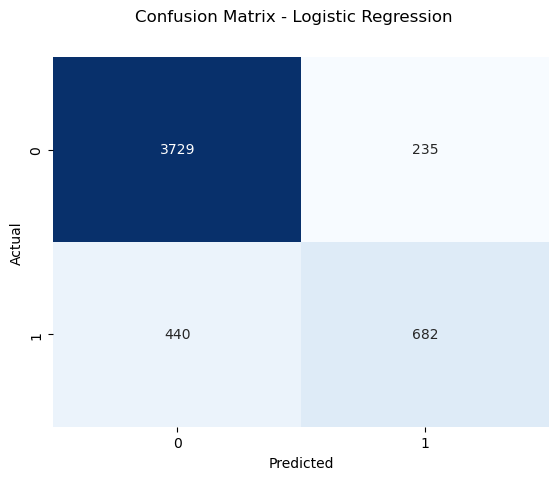

In [135]:
# Display the confusion matrix of the model using heatmap
conf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.suptitle('Confusion Matrix - Logistic Regression')
plt.show()

## *CatBoost Classifier*

In [71]:
# Import the CatBoostClassifier from the catboost library
from catboost import CatBoostClassifier, Pool

In [78]:
# Categorical features list
cat_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
# Separate features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
# Create CatBoost train Pool 
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
# Create a test Pool
test_pool = Pool(data=X_test, cat_features=cat_features)

## *Model Training and Evaluation*

In [90]:
# Define a function to evaluate the model
def tuning_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

In [94]:
# Baseline Model
print("\n--- Baseline Model (Default Parameters) ---")
catboost_baseline = CatBoostClassifier(verbose=0, random_seed=42,auto_class_weights='Balanced')
catboost_baseline.fit(train_pool)
print("Baseline Model Performance:")
tuning_eval(catboost_baseline, test_pool, y_test)


--- Baseline Model (Default Parameters) ---
Baseline Model Performance:
Accuracy: 0.9231
Recall: 0.7977
Precision: 0.8451
F1 Score: 0.8207
ROC AUC: 0.9479


In [95]:
#  Iterations and Learning Rate
print("\n--- Adjusted Iterations and Learning Rate ---")
catboost_tuned = CatBoostClassifier(verbose=0, random_seed=42, iterations=1500, learning_rate=0.03,auto_class_weights='Balanced')
catboost_tuned.fit(train_pool)
print("Performance with Adjusted Iterations and Learning Rate:")
tuning_eval(catboost_tuned, test_pool, y_test)


--- Adjusted Iterations and Learning Rate ---
Performance with Adjusted Iterations and Learning Rate:
Accuracy: 0.9233
Recall: 0.7995
Precision: 0.8446
F1 Score: 0.8214
ROC AUC: 0.9484


In [96]:
# Best Combined Configuration
print("\n--- Best Combined Configuration (Early Stopping + Tuned Parameters) ---")
catboost_combined = CatBoostClassifier(verbose=0, random_seed=42, iterations=2000, learning_rate=0.03, early_stopping_rounds=100 ,auto_class_weights='Balanced')
catboost_combined.fit(train_pool)
print("Performance with Combined Configuration:")
tuning_eval(catboost_combined, test_pool, y_test)


--- Best Combined Configuration (Early Stopping + Tuned Parameters) ---
Performance with Combined Configuration:
Accuracy: 0.9253
Recall: 0.8030
Precision: 0.8500
F1 Score: 0.8258
ROC AUC: 0.9488


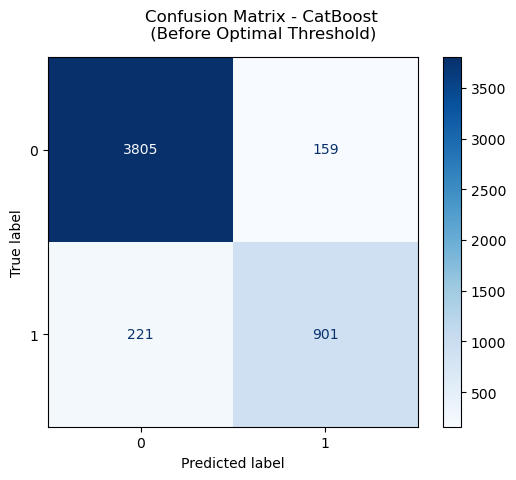

In [136]:
# Display Confusion matrix
y_pred = catboost_combined.predict(test_pool)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_combined.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.suptitle("Confusion Matrix - CatBoost\n (Before Optimal Threshold)")
plt.show()

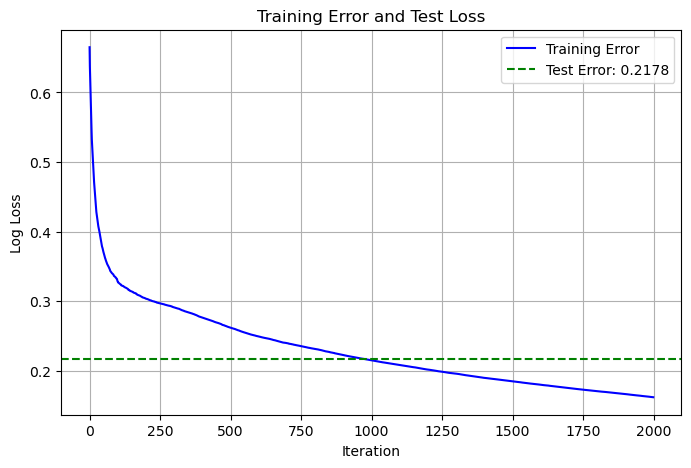

In [103]:
# Retrieve the evaluation results
eval_results = catboost_combined.evals_result_

# Extract the training error (Log Loss)
train_error = eval_results['learn']['Logloss']

# Calculate the Test Loss (Log Loss)
y_test_proba = catboost_combined.predict_proba(test_pool)
test_loss = log_loss(y_test, y_test_proba)

# Plot Training Error and Test Loss
plt.figure(figsize=(8, 5))
plt.plot(train_error, label='Training Error', color='blue')
plt.axhline(y=test_loss, color='green', linestyle='--', label=f'Test Error: {test_loss:.4f}')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training Error and Test Loss')
plt.legend()
plt.grid()
plt.show()

## *Feature Importance Analysis*

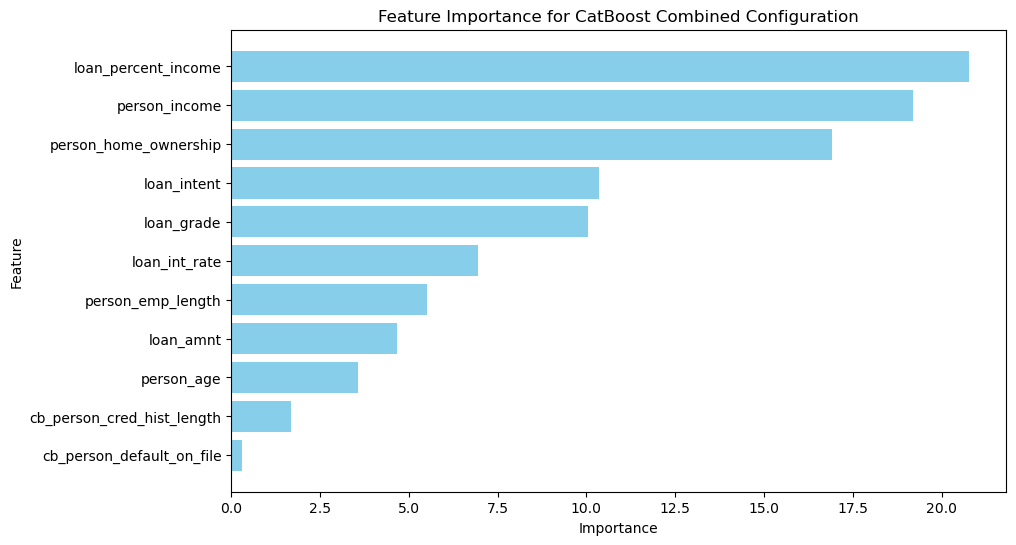

In [104]:
# Get feature importances
feature_importances = catboost_combined.get_feature_importance()
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for CatBoost Combined Configuration')
plt.gca().invert_yaxis()  # Reverse the order for a better look
plt.show()

## *Business Cost Optimization*

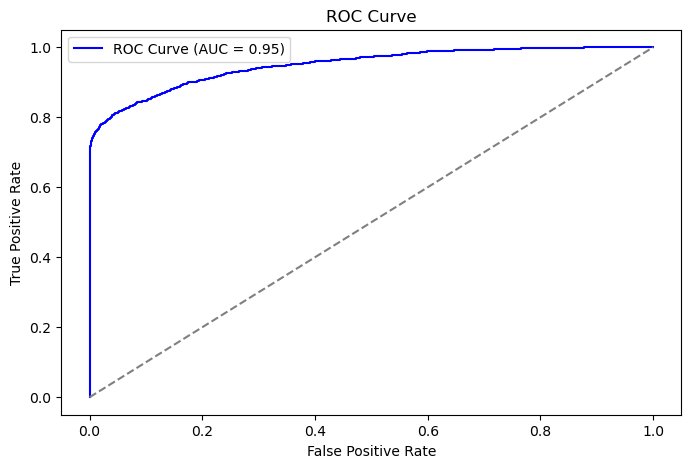

In [107]:
# Compute ROC curve and AUC
y_pred_proba = catboost_combined.predict_proba(X_test)[:, 1]  # Probability scores
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guess
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [145]:
cost_fp = 1000 # Business cost of rejecting good customers (missed oppurtunity)
cost_fn = 10000 # Business cost of approving bad customers (missed defaulters)

### *Finding Optimal Threshold*

In [110]:
def compute_cost(y_true, y_prob, threshold, cost_fp, cost_fn):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * cost_fp + fn * cost_fn

# Predict probabilities
y_probs = catboost_combined.predict_proba(X_test)[:, 1]

# Find optimal threshold
thresholds = np.linspace(0, 1, 101)
costs = [compute_cost(y_test, y_probs, t, cost_fp, cost_fn) for t in thresholds]
optimal_threshold = thresholds[np.argmin(costs)]


final_preds = (y_probs >= optimal_threshold).astype(int)
print("Optimal Threshold:", optimal_threshold)
print("Total Cost:", compute_cost(y_test, y_probs, optimal_threshold, cost_fp, cost_fn))
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print(classification_report(y_test, final_preds))



Optimal Threshold: 0.21
Total Cost: 1802000
ROC AUC: 0.9487591982027195
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      3964
           1       0.52      0.93      0.66      1122

    accuracy                           0.79      5086
   macro avg       0.75      0.84      0.76      5086
weighted avg       0.87      0.79      0.81      5086



In [122]:
# --- Compare business cost at threshold = 0.5 (default)
threshold_default = 0.5
cost_default = compute_cost(y_test, y_probs, threshold_default, cost_fp, cost_fn)

# --- Already computed threshold = 0.21
threshold_optimal = optimal_threshold
cost_optimal = compute_cost(y_test, y_probs, threshold_optimal, cost_fp, cost_fn)

# --- Print the results
print(f"Cost at threshold 0.50: ${cost_default:,}")
print(f"Cost at optimal threshold {threshold_optimal:.2f}: ${cost_optimal:,}")
print(f"Cost saved: ${cost_default - cost_optimal:,}")


Cost at threshold 0.50: $2,369,000
Cost at optimal threshold 0.21: $1,802,000
Cost saved: $567,000


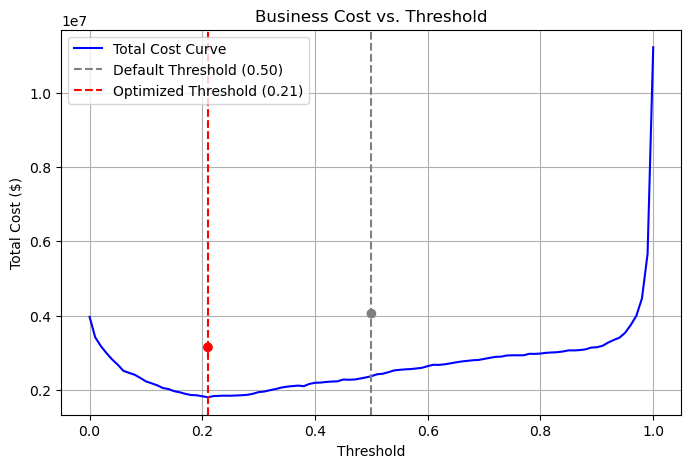

In [124]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, costs, label="Total Cost Curve", color='blue')
plt.axvline(x=0.50, color='gray', linestyle='--', label='Default Threshold (0.50)')
plt.axvline(x=0.21, color='red', linestyle='--', label='Optimized Threshold (0.21)')
plt.scatter([0.50, 0.21], [4052000, 3146000], color=['gray', 'red'], zorder=5)
plt.title("Business Cost vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Total Cost ($)")
plt.legend()
plt.grid(True)
plt.show()


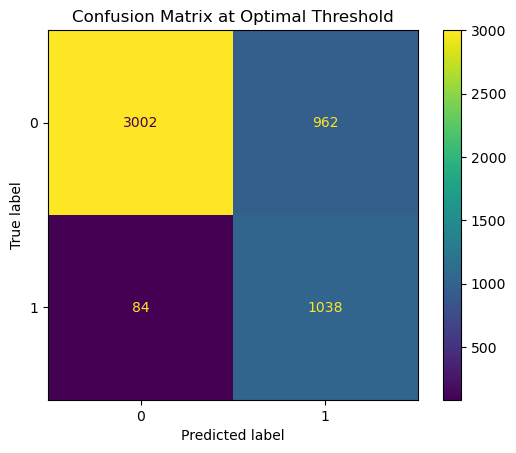

In [125]:
ConfusionMatrixDisplay.from_predictions(y_test, final_preds)
plt.title("Confusion Matrix at Optimal Threshold")
plt.show()

# *Conclusion*

<p style='font-size:20px;'><i>This project effectively predicted loan defaults and optimized business costs using machine learning.</i> </p>
<ul style='font-size:20px;'><i>
    <li>Logistic Regression achieved an accuracy of 87%, with a recall of 61% for defaulters.</li>
    <li>CatBoost model outperformed logistic regression with:</li>
    <ul>
      <li>Accuracy: 92.5%</li>
      <li>Recall (defaulters): 80.3%</li>
      <li>F1 Score: 0.8258</li>
      <li>ROC AUC: 0.9488</li>
    </ul>
    <li>A cost-sensitive threshold of 0.21 was determined to minimize the business loss.</li>
</i></ul>